# PM2.5 Concentrations and Cardiovascular Disease

In [1]:
import numpy as np
import pandas as pd
!pip install sodapy
import statsmodels.api as sm
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

  Using cached sodapy-2.2.0-py2.py3-none-any.whl (15 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.21.3 requires tokenizers!=0.11.3,<0.13,>=0.11.1, but you have tokenizers 0.13.1 which is incompatible.
matminer 0.7.4 requires jsonschema>=3.2.0, but you have jsonschema 3.1.1 which is incompatible.
datasets 2.2.1 requires pyarrow>=6.0.0, but you have pyarrow 5.0.0 which is incompatible.


In [2]:
import random

random.seed(10)

In [3]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#fcqm-xrf4
results = client.get("7vdq-ztk9", where = "year = '2014'", limit = 10000000)

# Convert to pandas DataFrame
pm = pd.DataFrame.from_records(results)

In [4]:
cd = pd.read_csv('cd.csv')

In [5]:
cd = cd[cd['DataValue'] != 0]
cd = cd[cd['DataValueType'] == 'Crude Rate']

In [6]:
state = pd.read_csv('states.csv')
state = state.rename(columns={' st': "statefips"})
state['statefips'] = state['statefips'].astype('str')

In [7]:
merge = pm.merge(state, on = 'statefips')
merge['pm25_mean_pred'] = merge['pm25_mean_pred'].astype(float)

In [8]:
merge = merge.groupby('stname').mean().reset_index()
merge

,stname,pm25_mean_pred
0,Alabama,10.628984
1,Arizona,5.687440
2,Arkansas,9.703796
3,California,8.628624
4,Colorado,5.071340
5,Connecticut,7.768041
6,Delaware,9.300557
7,District of Columbia,9.799117
8,Florida,8.045730
9,Georgia,10.468843


In [79]:
cd['Question'].value_counts()

Hospitalization for heart failure among Medicare-eligible persons aged >= 65 years    4160
Mortality from total cardiovascular diseases                                          4090
Mortality from cerebrovascular disease (stroke)                                       4090
Mortality from diseases of the heart                                                  4090
Mortality from coronary heart disease                                                 4090
Mortality from heart failure                                                          3998
Hospitalization for stroke                                                            2608
Hospitalization for acute myocardial infarction                                       2608
Name: Question, dtype: int64

In [80]:
cd = cd.rename(columns = {'LocationDesc' : 'stname'})
check_confound = cd.merge(merge, on = 'stname')
check_confound['HighPM_or_not'] = np.where(check_confound['pm25_mean_pred'] > 9, True, False)
gender = check_confound[check_confound['StratificationCategory1'] == 'Gender']
race = check_confound[check_confound['StratificationCategory1'] == 'Race/Ethnicity']

Text(0.5, 1.0, 'Distribution of Gender among Patients in States with a Mean High PM 2.5 Concentration (>9) vs. not')

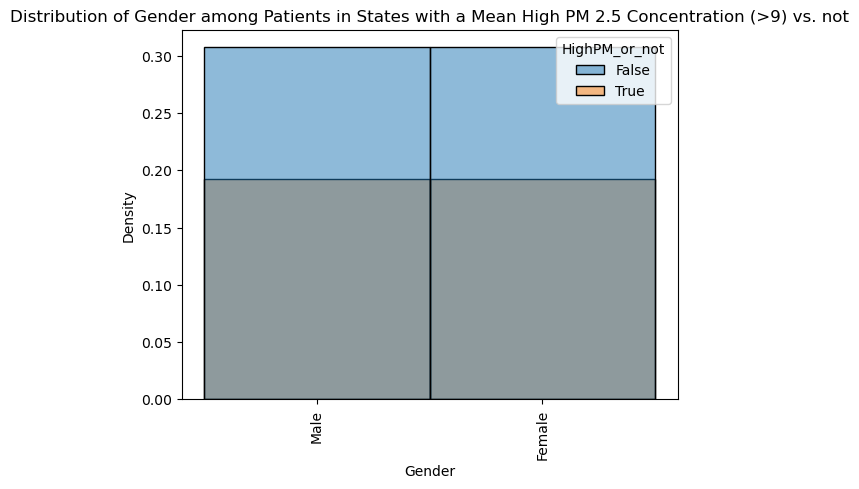

In [81]:
import matplotlib.pyplot as plt
sns.histplot(data=gender, x='Stratification1', hue='HighPM_or_not', stat='density', binwidth=0.5, alpha = 0.5)
plt.xticks(rotation=90);
plt.xlabel('Gender')
plt.title('Distribution of Gender among Patients in States with a Mean High PM 2.5 Concentration (>9) vs. not')

Text(0.5, 1.0, 'Distribution of Race/Ethnicity among Patients in States with a Mean High PM 2.5 Concentration (>9) vs. not')

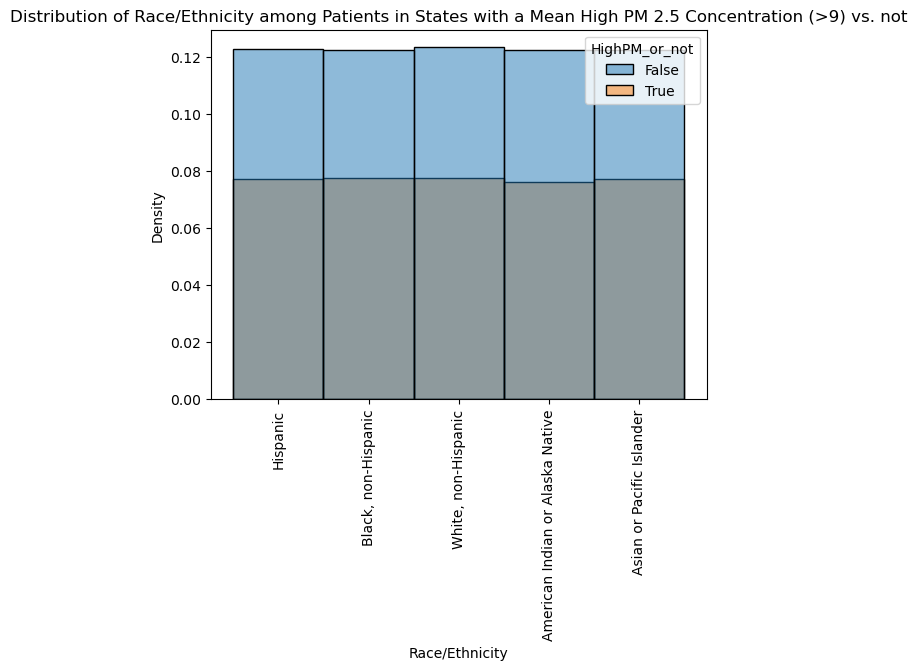

In [82]:
sns.histplot(data=race, x='Stratification1', hue='HighPM_or_not', stat='density', binwidth=0.5, alpha = 0.5)
plt.xticks(rotation=90);
plt.xlabel('Race/Ethnicity')
plt.title('Distribution of Race/Ethnicity among Patients in States with a Mean High PM 2.5 Concentration (>9) vs. not')

# Hospitalizations for heart failure among Medicare-eligible persons aged >= 65 years

In [11]:
cd['Question'].value_counts()

Hospitalization for heart failure among Medicare-eligible persons aged >= 65 years    4160
Mortality from total cardiovascular diseases                                          4090
Mortality from cerebrovascular disease (stroke)                                       4090
Mortality from diseases of the heart                                                  4090
Mortality from coronary heart disease                                                 4090
Mortality from heart failure                                                          3998
Hospitalization for stroke                                                            2608
Hospitalization for acute myocardial infarction                                       2608
Name: Question, dtype: int64

In [12]:
topcd = cd[cd['Question'] == 'Hospitalization for heart failure among Medicare-eligible persons aged >= 65 years'] # cases per 1000
topcd = topcd[topcd['YearEnd'] == 2014] # cases per 1000
topcd = topcd.groupby('LocationAbbr').mean()
topcd = topcd.reset_index()[['LocationAbbr','DataValue']]

In [13]:
state = pd.read_csv('states.csv')
state = state.rename(columns = {' stusps' : 'LocationAbbr'})
state['LocationAbbr'] = state['LocationAbbr'].str.replace(' ', '')
cleancd = topcd.merge(state, on = 'LocationAbbr')[['stname','DataValue']]
cleancd #Hospitalizations for heart failure

,stname,DataValue
0,Alaska,7.196000
1,Alabama,21.644000
2,Arkansas,20.564000
3,Arizona,14.767500
4,California,18.111250
5,Colorado,14.225714
6,Connecticut,21.018571
7,District of Columbia,18.010000
8,Delaware,18.358000
9,Florida,25.913750


In [14]:
vis1 = cleancd.merge(merge, on = 'stname')[['DataValue','pm25_mean_pred']]

In [15]:
vis1[vis1['pm25_mean_pred'] > 9]['DataValue'].mean() - vis1[vis1['pm25_mean_pred'] <= 9]['DataValue'].mean() #avg crude rate difference of indicator

4.112970112781959

In [219]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [220]:
betas_model = fit_OLS_model(vis1, 'DataValue', 'pm25_mean_pred')
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              745.7
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    6.76e-31
Time:                        16:33:56   Log-Likelihood:                         -145.89
No. Observations:                  49   AIC:                                      293.8
Df Residuals:                      48   BIC:                                      295.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

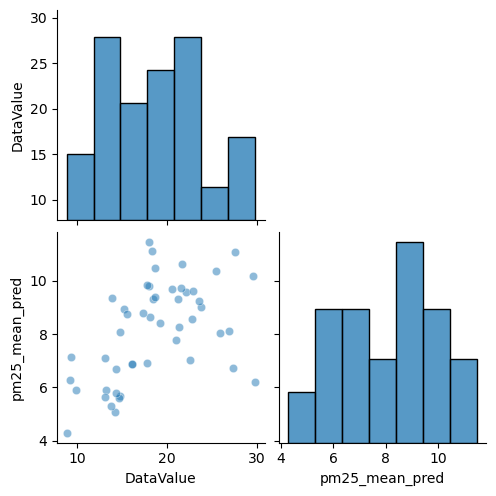

In [221]:
fig = sns.pairplot(vis1,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


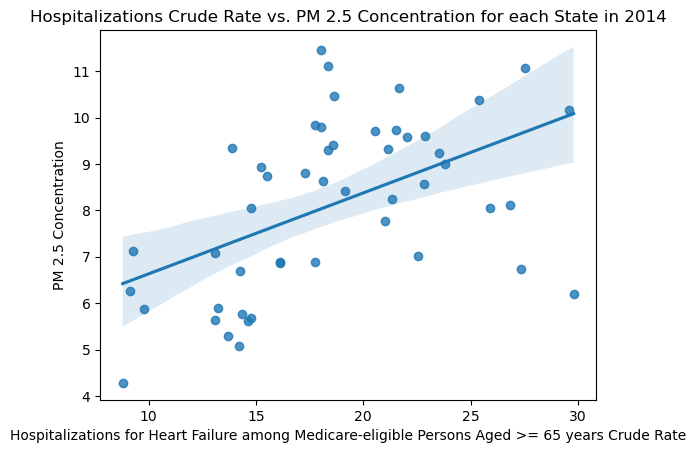

In [222]:
ax = sns.regplot(vis1['DataValue'], vis1['pm25_mean_pred'])
ax.set(xlabel='Hospitalizations for Heart Failure among Medicare-eligible Persons Aged >= 65 years Crude Rate', ylabel='PM 2.5 Concentration')
plt.title('Hospitalizations Crude Rate vs. PM 2.5 Concentration for each State in 2014')
plt.show()

In [229]:
import scipy.stats
r = scipy.stats.pearsonr(vis1['pm25_mean_pred'], vis1['DataValue'])
r[0]

0.5062507230874393

# Mortality from total cardiovascular diseases

In [230]:
topcd = cd[cd['Question'] == 'Mortality from total cardiovascular diseases']
topcd = topcd[topcd['YearEnd'] == 2014]
topcd = topcd.groupby('LocationAbbr').mean() #cases per 100,000 (mean crude rate for each state)
topcd = topcd.reset_index()[['LocationAbbr','DataValue']]

In [231]:
state = pd.read_csv('states.csv')
state = state.rename(columns = {' stusps' : 'LocationAbbr'})
state['LocationAbbr'] = state['LocationAbbr'].str.replace(' ', '')
cleancd = topcd.merge(state, on = 'LocationAbbr')[['stname','DataValue']]
cleancd #crude rate average for this indicator based on state

,stname,DataValue
0,Alaska,126.471429
1,Alabama,233.250000
2,Arkansas,246.371429
3,Arizona,172.862500
4,California,204.087500
5,Colorado,145.362500
6,Connecticut,191.071429
7,District of Columbia,222.666667
8,Delaware,208.457143
9,Florida,227.700000


In [232]:
vis1 = cleancd.merge(merge, on = 'stname')[['DataValue','pm25_mean_pred']]

In [233]:
vis1[vis1['pm25_mean_pred'] > 9]['DataValue'].mean() - vis1[vis1['pm25_mean_pred'] <= 9]['DataValue'].mean() #avg crude rate difference of indicator

20.28066290726818

In [234]:
betas_model = fit_OLS_model(vis1, 'DataValue', 'pm25_mean_pred')
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              762.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    4.05e-31
Time:                        16:36:05   Log-Likelihood:                         -262.94
No. Observations:                  49   AIC:                                      527.9
Df Residuals:                      48   BIC:                                      529.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

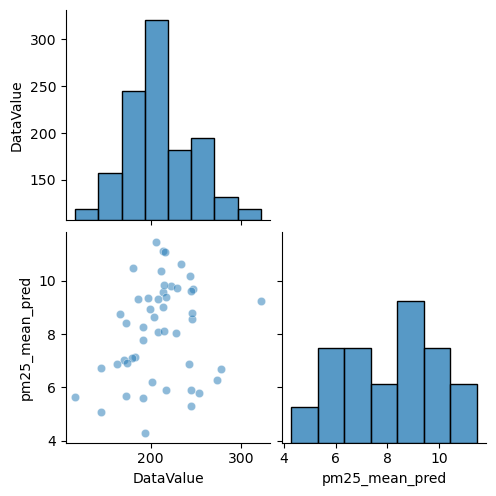

In [235]:
fig = sns.pairplot(vis1,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


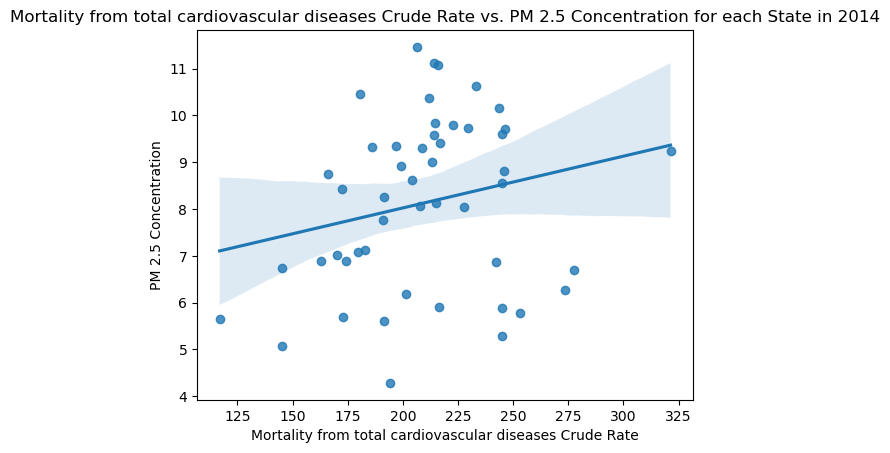

In [236]:
ax = sns.regplot(vis1['DataValue'], vis1['pm25_mean_pred'])
ax.set(xlabel='Mortality from total cardiovascular diseases Crude Rate', ylabel='PM 2.5 Concentration')
plt.title('Mortality from total cardiovascular diseases Crude Rate vs. PM 2.5 Concentration for each State in 2014')
plt.show()

In [237]:
import scipy.stats
r = scipy.stats.pearsonr(vis1['pm25_mean_pred'], vis1['DataValue'])
r[0]

0.22398443196382123

# Mortality from cerebrovascular disease (stroke)

In [238]:
topcd = cd[cd['Question'] == 'Mortality from cerebrovascular disease (stroke)']
topcd = topcd[topcd['YearEnd'] == 2014]
topcd = topcd.groupby('LocationAbbr').mean() #cases per 100,000 (mean crude rate for each state)
topcd = topcd.reset_index()[['LocationAbbr','DataValue']]

In [239]:
state = pd.read_csv('states.csv')
state = state.rename(columns = {' stusps' : 'LocationAbbr'})
state['LocationAbbr'] = state['LocationAbbr'].str.replace(' ', '')
cleancd = topcd.merge(state, on = 'LocationAbbr')[['stname','DataValue']]
cleancd #crude rate average for this indicator based on state

,stname,DataValue
0,Alaska,23.240000
1,Alabama,55.320000
2,Arkansas,53.420000
3,Arizona,28.187500
4,California,34.437500
5,Colorado,27.457143
6,Connecticut,30.866667
7,District of Columbia,32.780000
8,Delaware,46.520000
9,Florida,42.357143


In [240]:
vis1 = cleancd.merge(merge, on = 'stname')[['DataValue','pm25_mean_pred']]

In [241]:
vis1[vis1['pm25_mean_pred'] > 9]['DataValue'].mean() - vis1[vis1['pm25_mean_pred'] <= 9]['DataValue'].mean() #avg crude rate difference of indicator

5.7730146198830425

In [242]:
betas_model = fit_OLS_model(vis1, 'DataValue', 'pm25_mean_pred')
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              769.5
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    3.33e-31
Time:                        16:36:18   Log-Likelihood:                         -179.94
No. Observations:                  49   AIC:                                      361.9
Df Residuals:                      48   BIC:                                      363.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

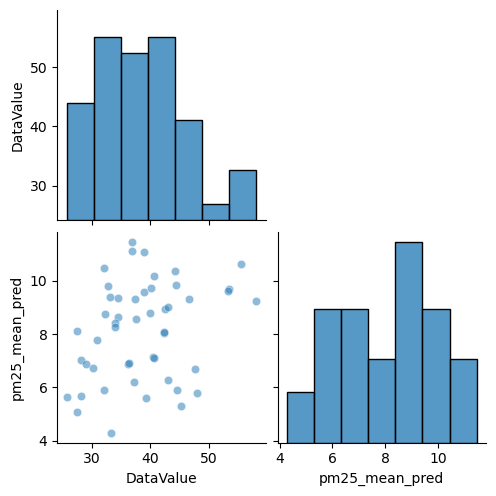

In [243]:
fig = sns.pairplot(vis1,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


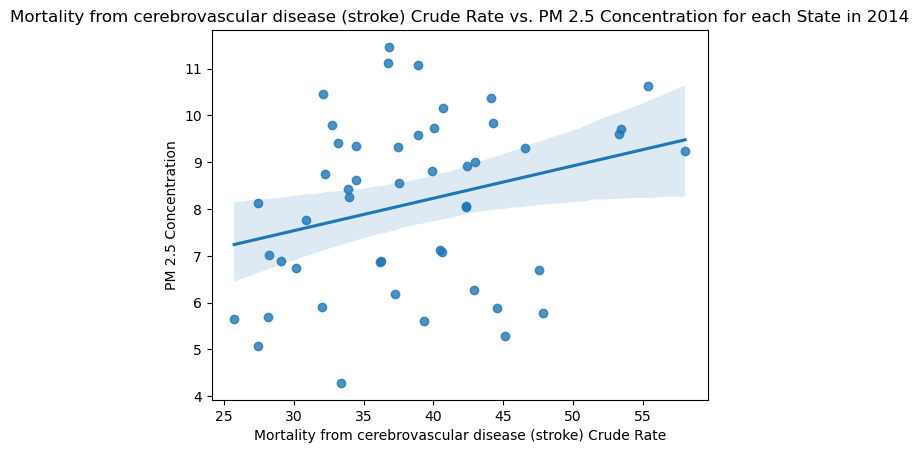

In [244]:
ax = sns.regplot(vis1['DataValue'], vis1['pm25_mean_pred'])
ax.set(xlabel='Mortality from cerebrovascular disease (stroke) Crude Rate', ylabel='PM 2.5 Concentration')
plt.title('Mortality from cerebrovascular disease (stroke) Crude Rate vs. PM 2.5 Concentration for each State in 2014')
plt.show()

In [245]:
import scipy.stats
r = scipy.stats.pearsonr(vis1['pm25_mean_pred'], vis1['DataValue'])
r[0]

0.2861011640168624

# Mortality from diseases of the heart

In [246]:
topcd = cd[cd['Question'] == 'Mortality from diseases of the heart']
topcd = topcd[topcd['YearEnd'] == 2014]
topcd = topcd.groupby('LocationAbbr').mean() #cases per 100,000 (mean crude rate for each state)
topcd = topcd.reset_index()[['LocationAbbr','DataValue']]

In [247]:
state = pd.read_csv('states.csv')
state = state.rename(columns = {' stusps' : 'LocationAbbr'})
state['LocationAbbr'] = state['LocationAbbr'].str.replace(' ', '')
cleancd = topcd.merge(state, on = 'LocationAbbr')[['stname','DataValue']]
cleancd #crude rate average for this indicator based on state

,stname,DataValue
0,Alaska,103.650000
1,Alabama,201.500000
2,Arkansas,191.285714
3,Arizona,125.812500
4,California,149.900000
5,Colorado,107.075000
6,Connecticut,147.957143
7,District of Columbia,176.733333
8,Delaware,158.271429
9,Florida,171.312500


In [248]:
vis1 = cleancd.merge(merge, on = 'stname')[['DataValue','pm25_mean_pred']]

In [249]:
vis1[vis1['pm25_mean_pred'] > 9]['DataValue'].mean() - vis1[vis1['pm25_mean_pred'] <= 9]['DataValue'].mean() #avg crude rate difference of indicator

16.94888241436928

In [250]:
betas_model = fit_OLS_model(vis1, 'DataValue', 'pm25_mean_pred')
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              733.9
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    9.68e-31
Time:                        16:36:27   Log-Likelihood:                         -250.81
No. Observations:                  49   AIC:                                      503.6
Df Residuals:                      48   BIC:                                      505.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

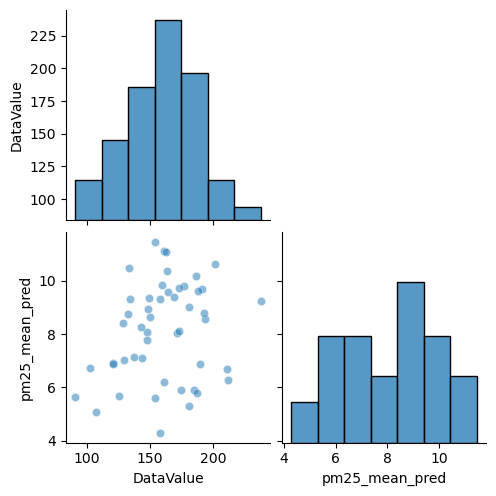

In [251]:
fig = sns.pairplot(vis1,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


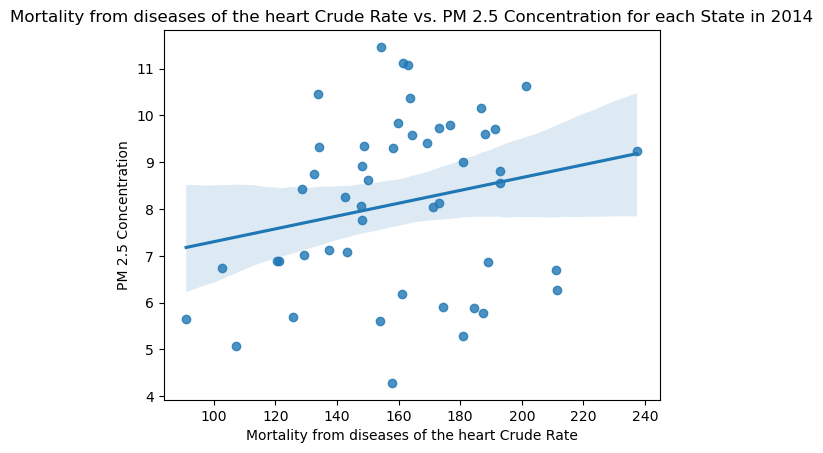

In [252]:
ax = sns.regplot(vis1['DataValue'], vis1['pm25_mean_pred'])
ax.set(xlabel='Mortality from diseases of the heart Crude Rate', ylabel='PM 2.5 Concentration')
plt.title('Mortality from diseases of the heart Crude Rate vs. PM 2.5 Concentration for each State in 2014')
plt.show()

In [253]:
import scipy.stats
r = scipy.stats.pearsonr(vis1['pm25_mean_pred'], vis1['DataValue'])
r[0]

0.22374073207340223

# Mortality from coronary heart disease 

In [254]:
topcd = cd[cd['Question'] == 'Mortality from coronary heart disease']
topcd = topcd[topcd['YearEnd'] == 2014]
topcd = topcd.groupby('LocationAbbr').mean() #cases per 100,000 (mean crude rate for each state)
topcd = topcd.reset_index()[['LocationAbbr','DataValue']]

In [255]:
state = pd.read_csv('states.csv')
state = state.rename(columns = {' stusps' : 'LocationAbbr'})
state['LocationAbbr'] = state['LocationAbbr'].str.replace(' ', '')
cleancd = topcd.merge(state, on = 'LocationAbbr')[['stname','DataValue']]
cleancd #crude rate average for this indicator based on state

,stname,DataValue
0,Alaska,64.740000
1,Alabama,89.516667
2,Arkansas,128.900000
3,Arizona,83.137500
4,California,95.662500
5,Colorado,59.100000
6,Connecticut,76.214286
7,District of Columbia,125.360000
8,Delaware,129.120000
9,Florida,109.500000


In [256]:
vis1 = cleancd.merge(merge, on = 'stname')[['DataValue','pm25_mean_pred']]

In [257]:
vis1[vis1['pm25_mean_pred'] > 9]['DataValue'].mean() - vis1[vis1['pm25_mean_pred'] <= 9]['DataValue'].mean() #avg crude rate difference of indicator

12.105560568086872

In [258]:
betas_model = fit_OLS_model(vis1, 'DataValue', 'pm25_mean_pred')
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              554.5
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    5.09e-28
Time:                        16:36:36   Log-Likelihood:                         -233.22
No. Observations:                  49   AIC:                                      468.4
Df Residuals:                      48   BIC:                                      470.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

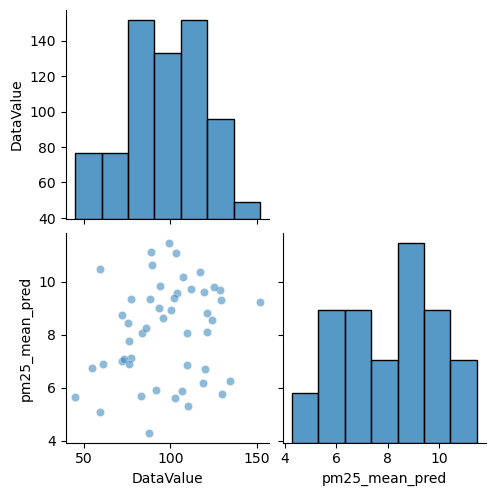

In [259]:
fig = sns.pairplot(vis1,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


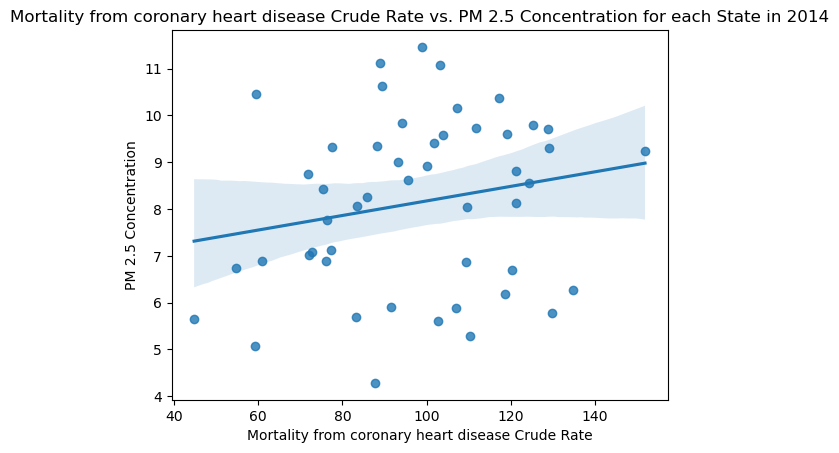

In [260]:
ax = sns.regplot(vis1['DataValue'], vis1['pm25_mean_pred'])
ax.set(xlabel='Mortality from coronary heart disease Crude Rate', ylabel='PM 2.5 Concentration')
plt.title('Mortality from coronary heart disease Crude Rate vs. PM 2.5 Concentration for each State in 2014')
plt.show()

In [261]:
import scipy.stats
r = scipy.stats.pearsonr(vis1['pm25_mean_pred'], vis1['DataValue'])
r[0]

0.20085058063437286

# EDA

In [26]:
eda = cleancd.merge(merge, on = 'stname').sort_values('pm25_mean_pred')

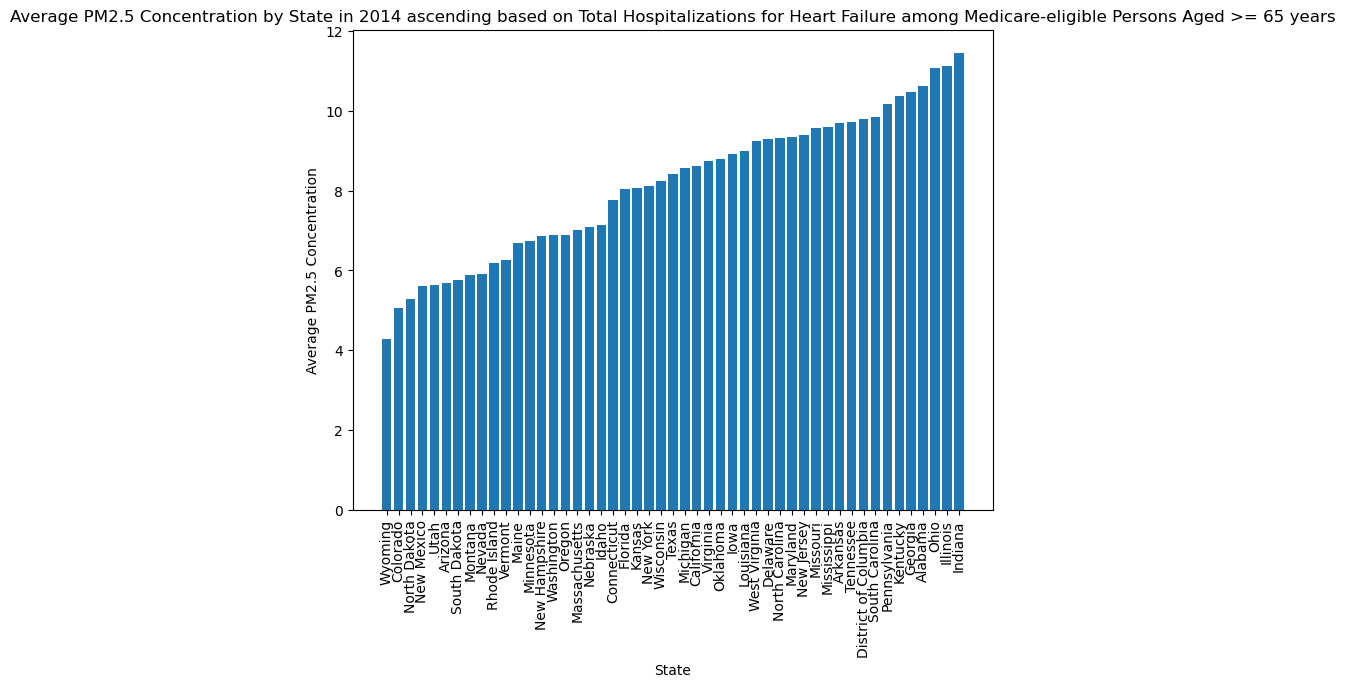

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/popularity_contest/reporter.py", line 105, in report_popularity
    libraries = get_used_libraries(initial_modules, current_modules)
  File "/opt/conda/lib/python3.9/site-packages/popularity_contest/reporter.py", line 74, in get_used_libraries
    all_packages = get_all_packages()
  File "/opt/conda/lib/python3.9/site-packages/popularity_contest/reporter.py", line 51, in get_all_packages
    for f in dist.files:
TypeError: 'NoneType' object is not iterable


In [27]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(eda['stname'], eda['pm25_mean_pred'])
plt.xticks(rotation='vertical')
plt.ylabel('Average PM2.5 Concentration')
plt.xlabel('State')
plt.title('Average PM2.5 Concentration by State in 2014 ascending based on Total Hospitalizations for Heart Failure among Medicare-eligible Persons Aged >= 65 years')
plt.show()